In [254]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Lectura sin formato
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print('\n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


/tmp/ipykernel_40650/3920657155.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)


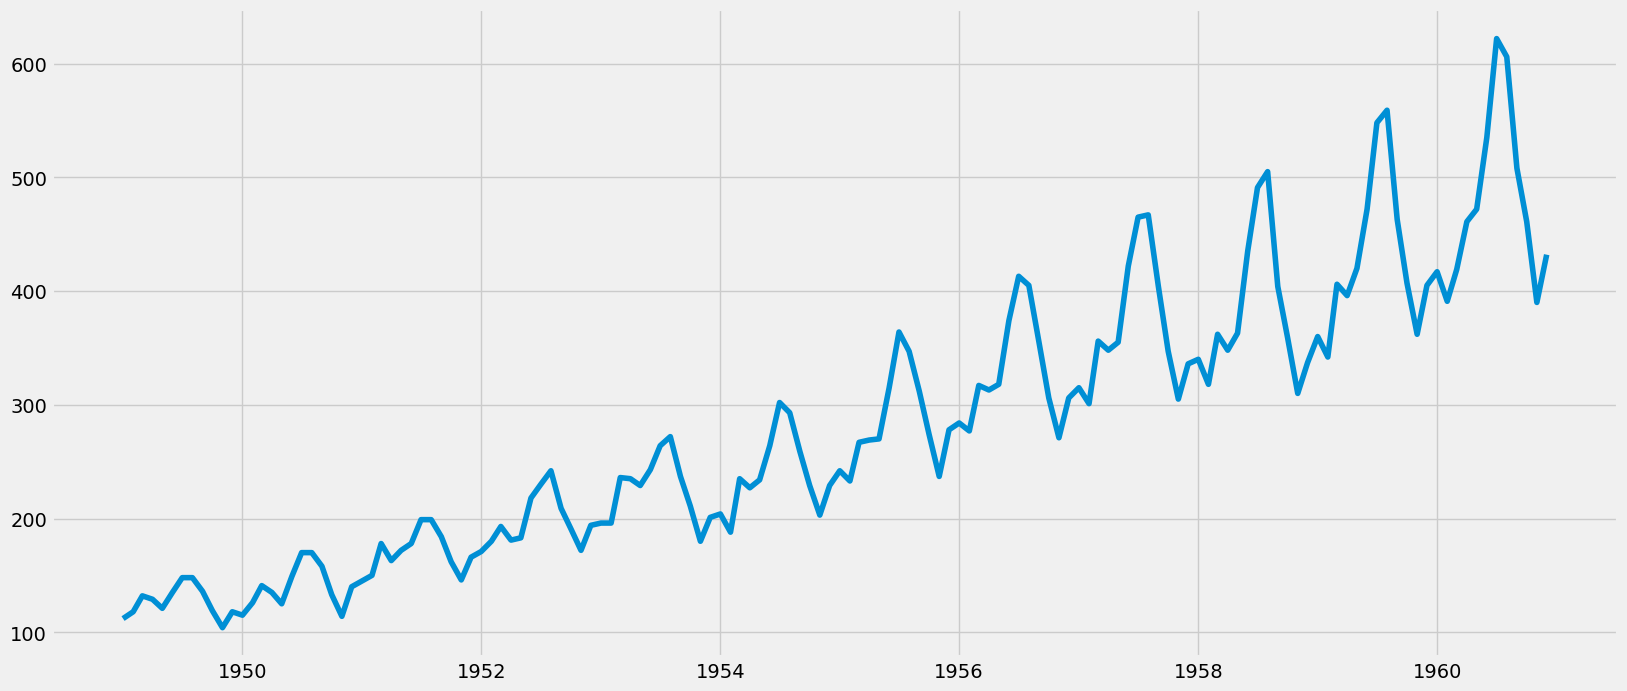

In [255]:
# Lectura con formato
import datetime
dateparse = lambda dates: datetime.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
ts = data['#Passengers'] # Serie temporal
ts_copy = ts.copy()
plt.style.use('fivethirtyeight')
plt.plot(ts)
plt.show()

In [256]:
import itertools
import statsmodels.api as sm

# Variables globales
endTrain = '1957-12-31'
startTest = '1958-01-01'
length = 12*3 # 10 años

y_train = ts[:endTrain]
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


# 1. ARIMA
Determinar los parámtros del modelo ARIMA con los que se obtenga el mejor ajuste en la serie AirPassengers. Valida el modelo en un periodo comprendido entre los años 1958, 1959 y 1960 (es decir, no deben emplearse datos de estos tres años para aprender los parámetros del modelo)

In [257]:
# Ajuste de hiperparámetros
mejor = np.inf
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < mejor:
                mejor = results.aic
                mejores_parametros = [param, param_seasonal]
        except:
            continue

/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS w

/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24076D+00    |proj g|=  1.63170D-03

At iterate    5    f=  3.24075D+00    |proj g|=  1.54665D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   8.514D-06   3.241D+00
  F =   3.2407461476971799     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


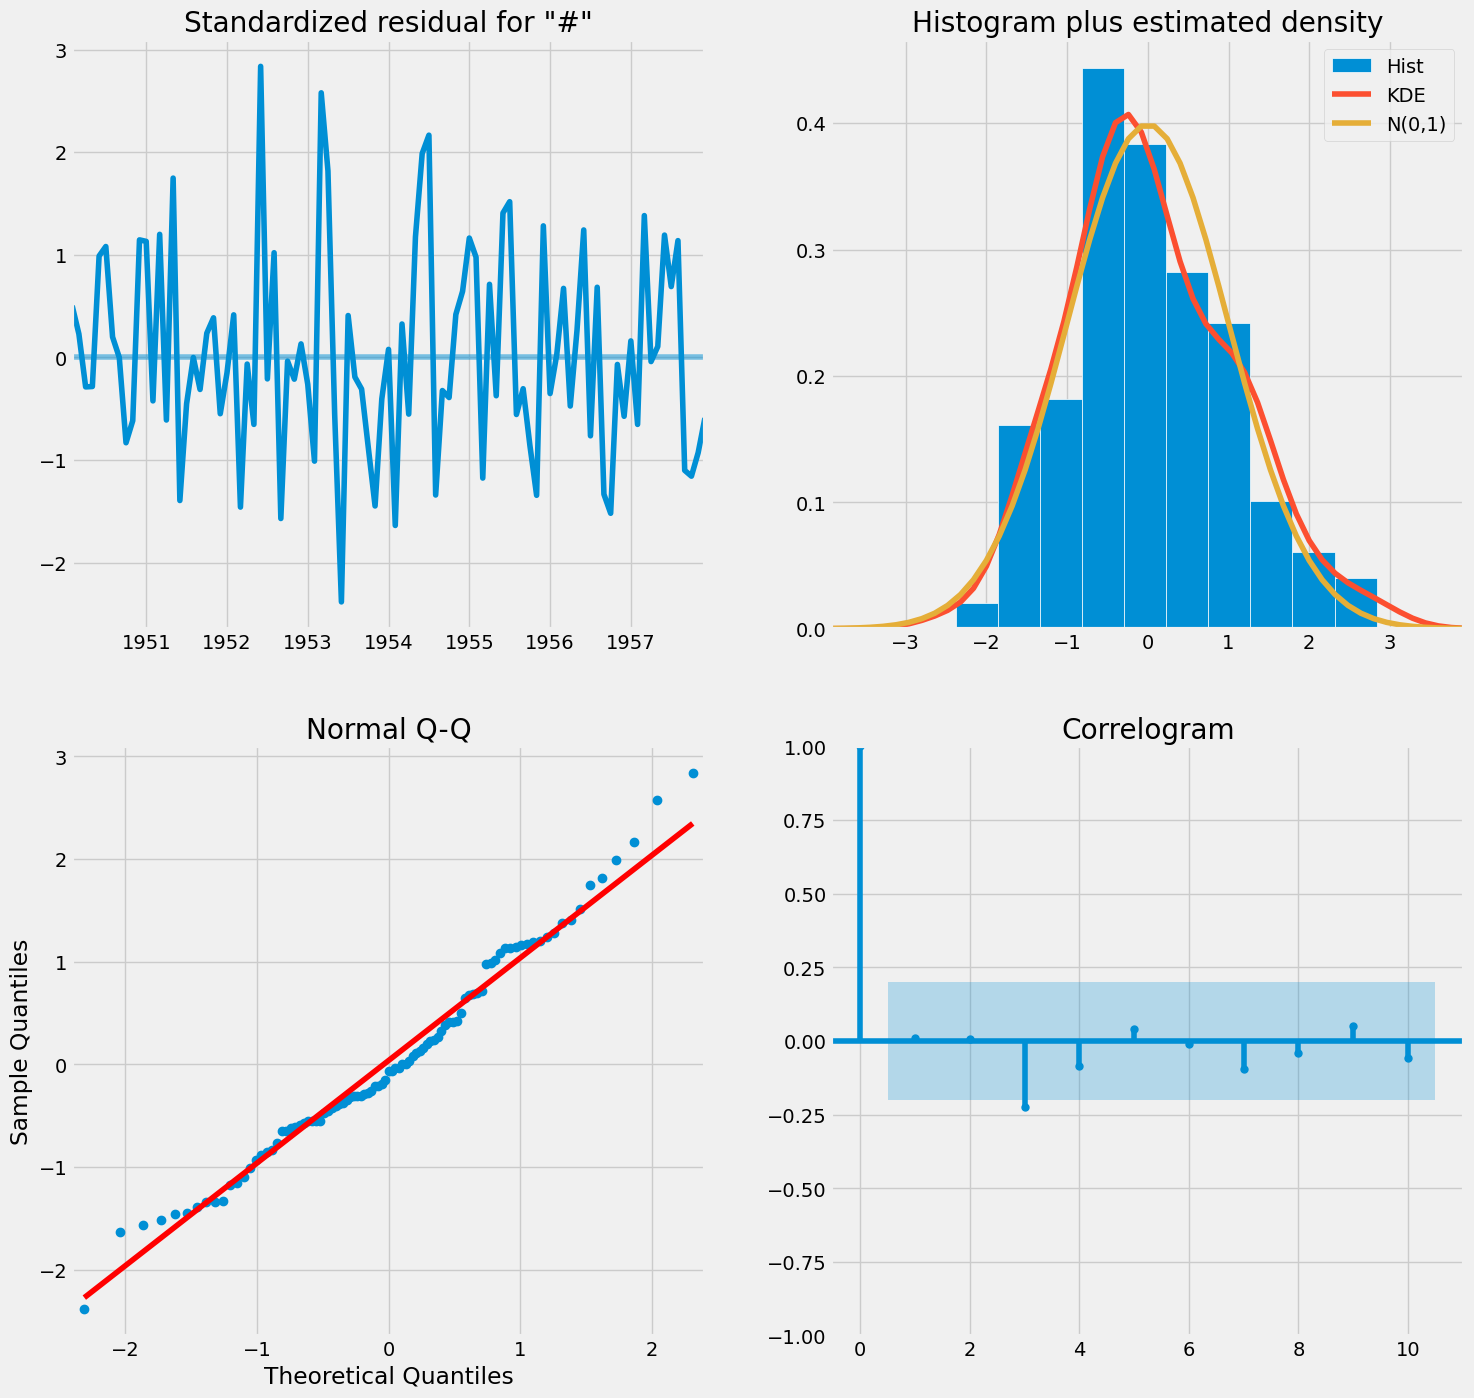

In [258]:
# Ajuste del modelo
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=mejores_parametros[0],
                                seasonal_order=mejores_parametros[1],
                                enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(16, 16))
plt.show()

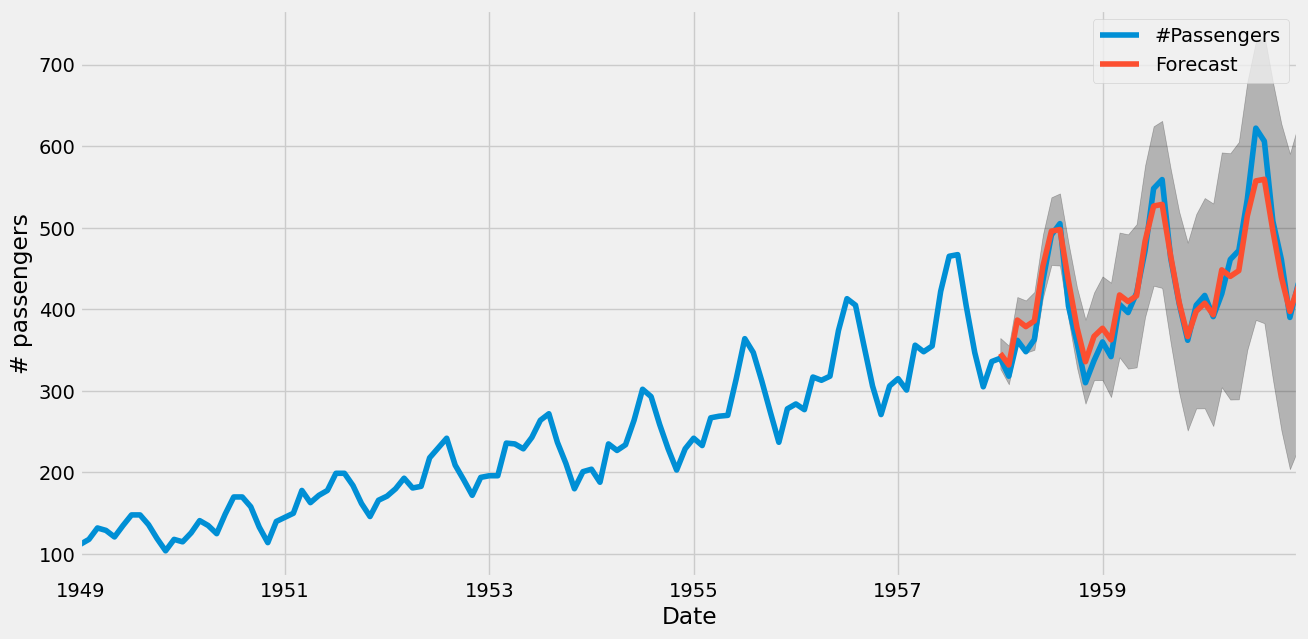

In [259]:
# Predicción a múltiples pasos
pred_uc = results.get_forecast(steps=length)
pred_ci = pred_uc.conf_int()
ax = data.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('# passengers')
plt.legend()
plt.show()

In [260]:
# Evaluación de la predicción
y_truth = data[startTest:]['#Passengers']
predicciones_arima = pred_uc.predicted_mean[y_truth.index]

mse = ((predicciones_arima - y_truth) ** 2).mean()
rele = (np.abs(predicciones_arima - y_truth)/y_truth*100).mean()
print('Error cuadrático medio ARIMA {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM ARIMA {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio ARIMA {}'.format(round(rele, 2)))

predicciones_arima = pred_uc.predicted_mean

Error cuadrático medio ARIMA 489.84
Raíz cuadrada de ECM ARIMA 22.13
Error porcentual medio ARIMA 4.15


# 2. Holt-Winters
Ajustar el modelo Holt-Winters a esta serie y comparar sus resultados en el mismo conjunto de test

Error cuadrático medio HW 695.68
Raíz cuadrada de ECM HW 26.38
Error porcentual medio HW 5.11


/home/mier/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


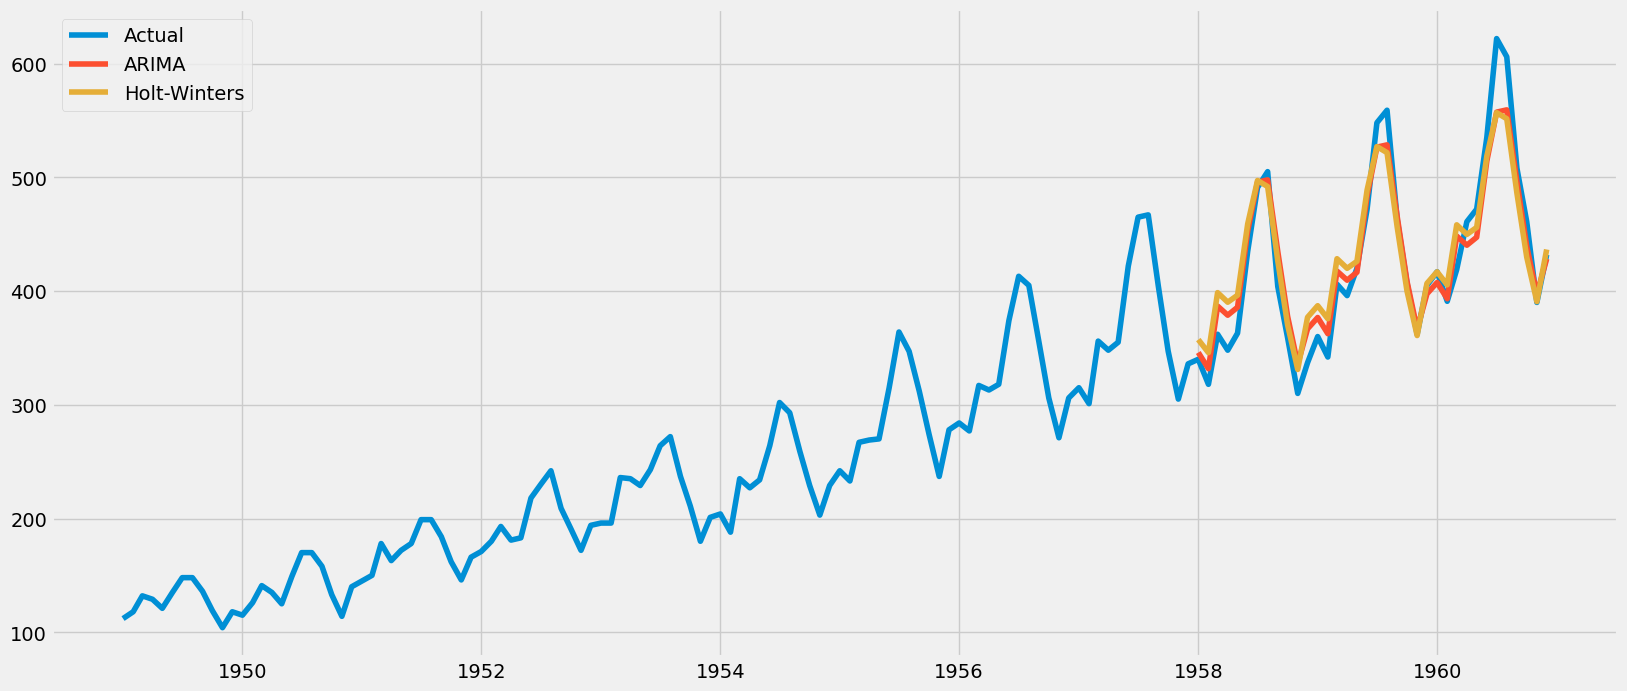

In [261]:
# ------------------------------------
# Holt-Winters
# ------------------------------------
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

from statsmodels.tsa.api import ExponentialSmoothing
hw_model = ExponentialSmoothing(
    y_train, trend='add', seasonal='add', seasonal_periods=12).fit()
predicciones_hw = hw_model.forecast(length)

mse = ((predicciones_hw - y_truth) ** 2).mean()
rele = (np.abs(predicciones_hw - y_truth)/y_truth*100).mean()
print('Error cuadrático medio HW {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM HW {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio HW {}'.format(round(rele, 2)))

plt.plot(ts, label="Actual")
plt.plot(predicciones_arima, label="ARIMA")
plt.plot(predicciones_hw, label="Holt-Winters")
plt.legend()
plt.show()

# 3. Prophet
Ajustar Prophet a los mismos datos y comparar los resultados (la parte de series múltiples no es aplicable a este problema)

In [262]:
y_train = data[:endTrain]
ejemplo = pd.DataFrame({"ds": list(y_train.index), "y": [ v[0] for v in y_train.values ]})

22:13:10 - cmdstanpy - INFO - Chain [1] start processing


22:13:10 - cmdstanpy - INFO - Chain [1] done processing


Error cuadrático medio PROPHET 695.68
Raíz cuadrada de ECM PROPHET 26.38
Error porcentual medio PROPHET 5.11


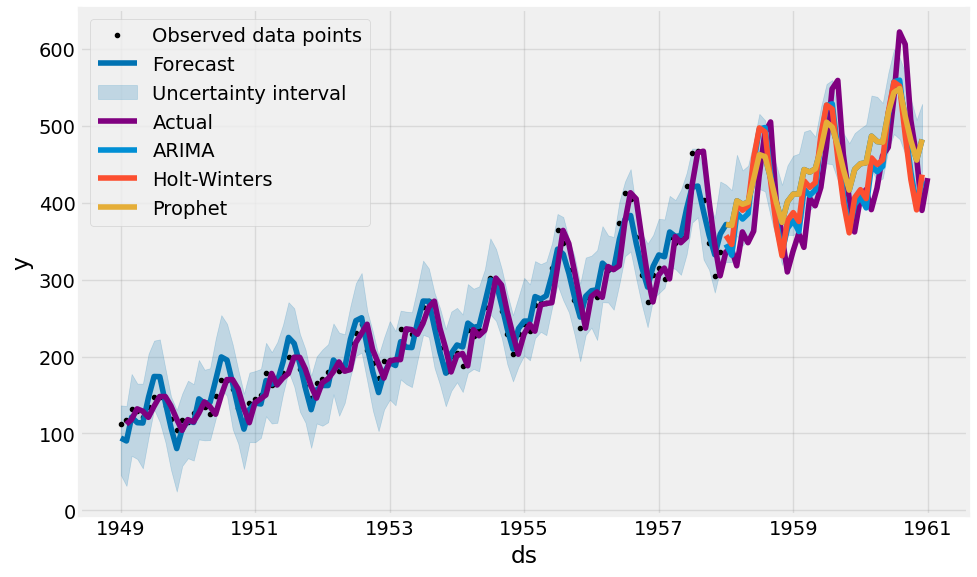

In [269]:
from prophet import Prophet
m = Prophet(interval_width=1)
m.fit(ejemplo)
forecast = m.predict(
    m.make_future_dataframe(periods=length, freq='MS')
)

fig1 = m.plot(forecast[
    ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
])

print('Error cuadrático medio PROPHET {}'.format(round(mse, 2)))
print('Raíz cuadrada de ECM PROPHET {}'.format(round(np.sqrt(mse), 2)))
print('Error porcentual medio PROPHET {}'.format(round(rele, 2)))

forecast = forecast.set_index('ds')
predicciones_prophet = forecast['yhat'][startTest:]

plt.plot(ts, label="Actual", color="purple")
plt.plot(predicciones_arima, label="ARIMA")
plt.plot(predicciones_hw, label="Holt-Winters")
plt.plot(predicciones_prophet, label="Prophet")
plt.legend()
plt.show()

# 4. DeepAR
Ajustar DeepAR a los mismos datos y comparar los resultados (la parte de datos múltiples no es aplicable a este problema)

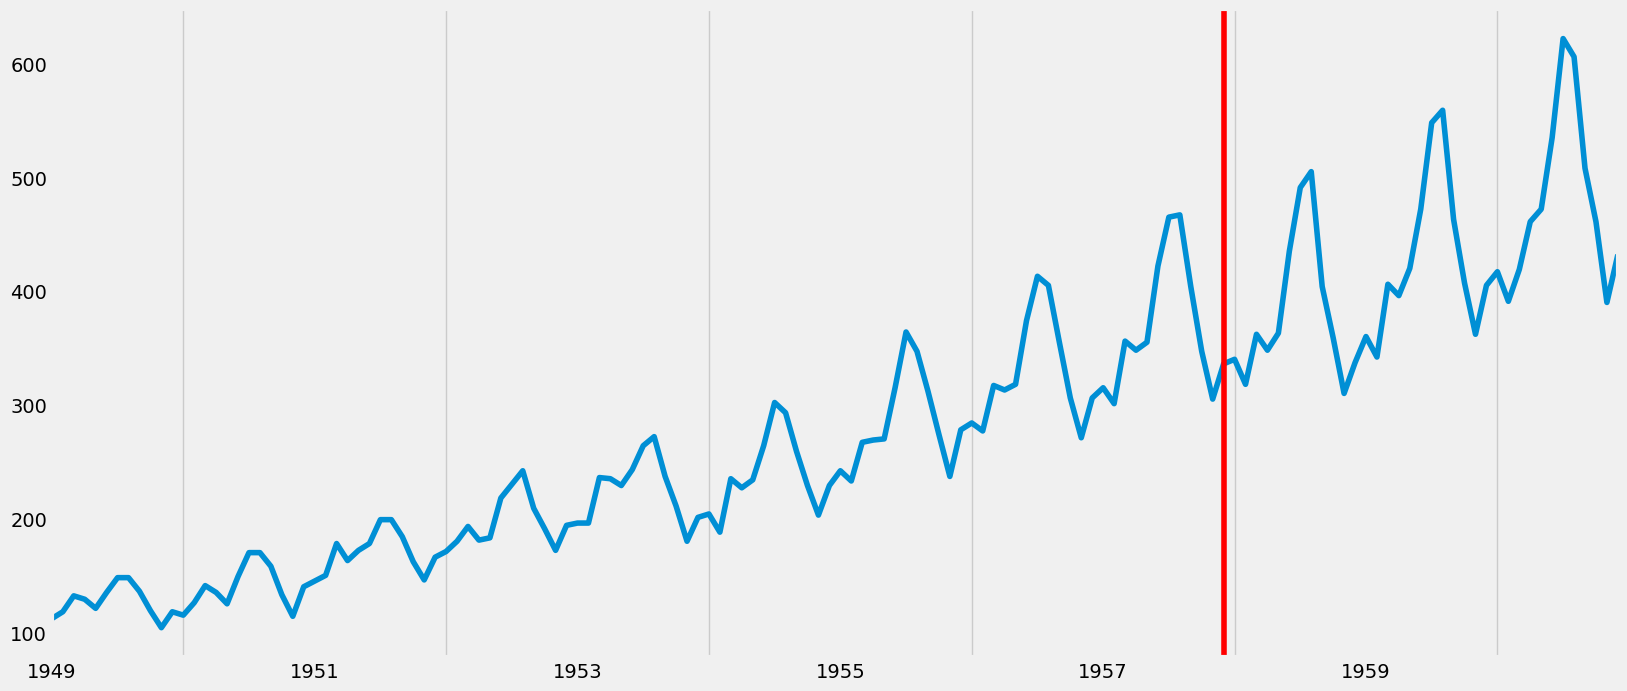

In [264]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.evaluation.backtest import make_evaluation_predictions

# Una variable "target", una fecha "start" y una frecuencia
training_data = ListDataset(
    [{"start": ts.index[0], "target": y_train['#Passengers']}], freq="M"
)

# Train + test
test_data = ListDataset(
    [{"start": ts.index[0], "target": ts}], freq="M"
)

to_pandas(test_data[0]).plot()
plt.axvline(y_train.index[-1], color='r')
plt.grid(which="both")
plt.show()

In [265]:
def plot_prob_forecasts(ts_entry, forecast_entry, plot_length, endTrain):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    forecast_entry.plot(show_label=True)
    ts_entry[-plot_length:].plot(ax=ax)
    plt.grid(which="both")
    plt.legend(loc="upper left")
    plt.axvline(pd.to_datetime(endTrain), lw=1, color='r')
    plt.show()

In [266]:
# prediction length: diferencia entre el final del train y el final del dataset
prediction_length = len(ts) - len(y_train)
estimator = DeepAREstimator(
	freq="M",
	prediction_length=prediction_length,
	cardinality=[1],
	trainer_kwargs={"max_epochs": 50, "accelerator": "cpu"}
)
predictor = estimator.train(training_data=training_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mier/.local/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                   | Out sizes   
------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 23.3 K | [[1, 1], [1, 1], [1, 72, 2], [1, 72], [1, 72], [1, 36, 2]] | [1, 100, 36]
------------------------------------------------------------------------------------------------------------------
23.3 K    Trainable params
0         Non-trainable params
23.3 K    Total params
0.093     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 5.18768 (best 5.18768), saving model to '/home/mier/uo/y4t1/Negocio/PL/p7/lightning_logs/version_46/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 4.21901 (best 4.21901), saving model to '/home/mier/uo/y4t1/Negocio/PL/p7/lightning_logs/version_46/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.88314 (best 3.88314), saving model to '/home/mier/uo/y4t1/Negocio/PL/p7/lightning_logs/version_46/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.73490 (best 3.73490), saving model to '/home/mier/uo/y4t1/Negocio/PL/p7/lightning_logs/version_46/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 3.57691 (best 3.57691), saving model to '/home/mier/uo/y4t1/Negocio/PL/p7/lightning_logs/version_46/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 

Number of sample paths: 100
Dimension of samples: (100, 36)
Start date of the forecast window: 1958-01
Frequency of the time series: <MonthEnd>


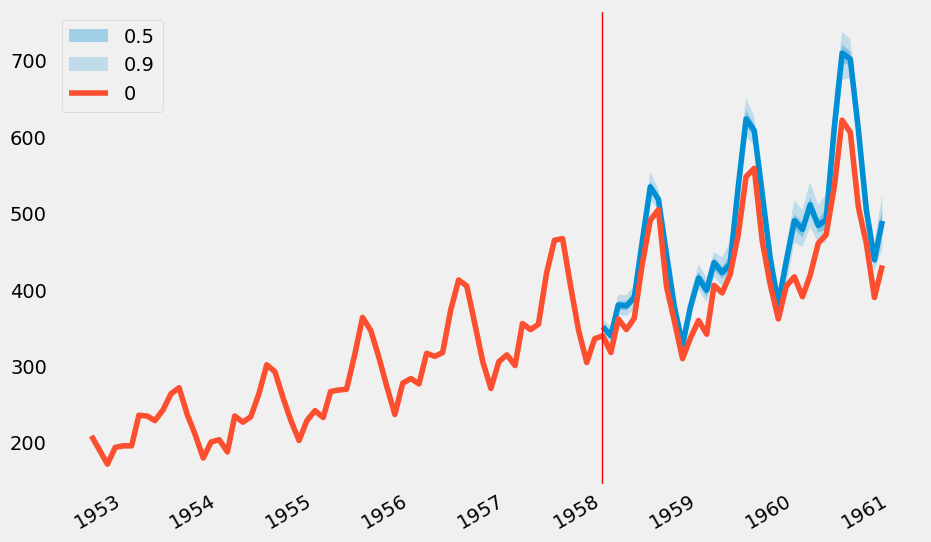

In [267]:
forecasts_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecasts_it)[0]
ts = list(ts_it)[0]

print(f"Number of sample paths: {forecasts.num_samples}")
print(f"Dimension of samples: {forecasts.samples.shape}")
print(f"Start date of the forecast window: {forecasts.start_date}")
print(f"Frequency of the time series: {forecasts.freq}")

plot_prob_forecasts(ts, forecasts, 100, endTrain)
plt.show()
predicciones_deepar = forecasts.mean


# 5. Comparación
Comparar entre sí las predicciones a largo plazo (años 1960 a 1970) de ARIMA, Holt Winters y Prophet

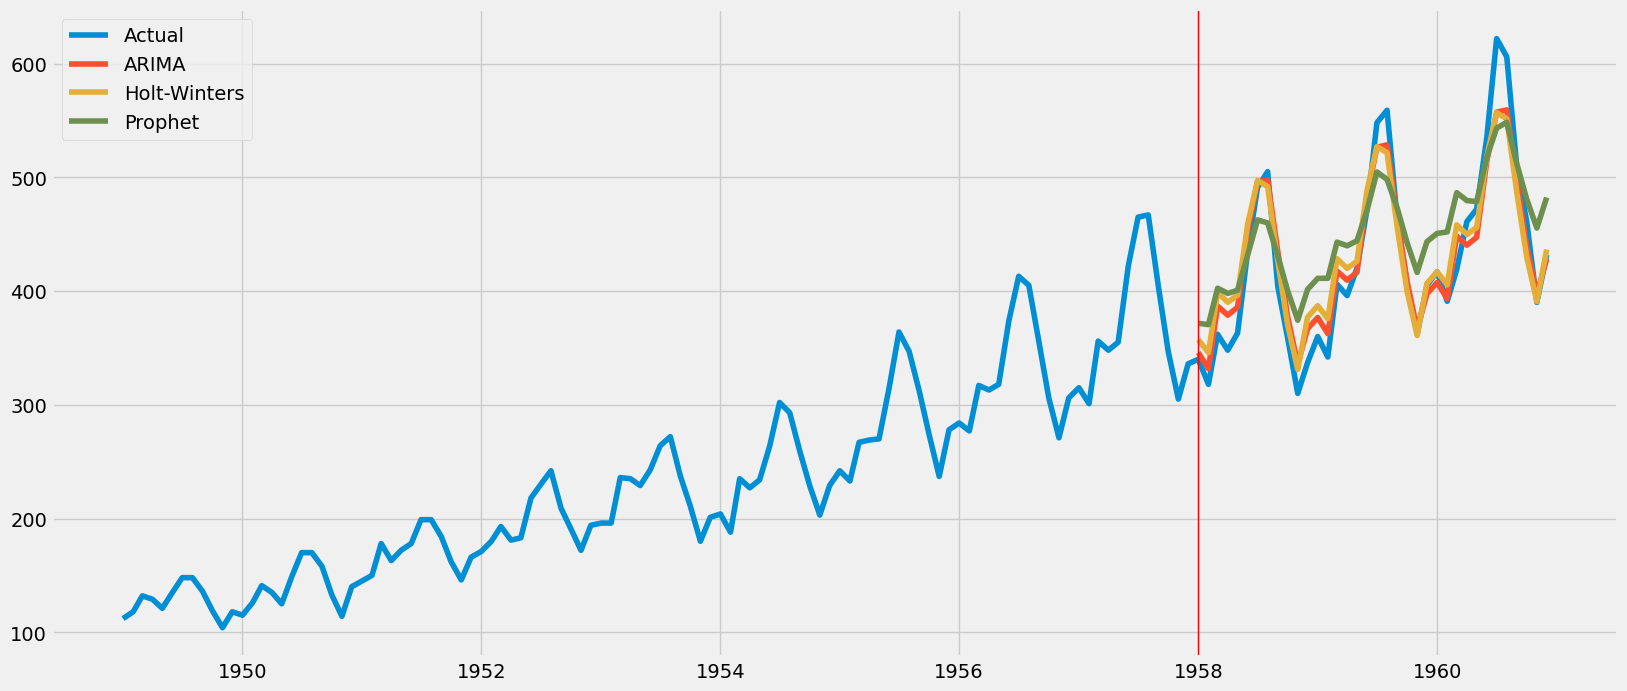

In [268]:
plt.plot(ts_copy, label="Actual")
plt.plot(predicciones_arima, label="ARIMA")
plt.plot(predicciones_hw, label="Holt-Winters")
plt.plot(predicciones_prophet, label="Prophet")
plt.axvline(pd.to_datetime(endTrain), lw=1, color='r')
plt.legend()
plt.show()